# First order ZV-MCMC estimates

Ce notebook répond à la **deuxième question** du projet.

Avec la méthode Ordinary-MCMC, nous avons déterminé l'estimateur en approximant l'espérance du vecteur de paramètres cible $ \boldsymbol{\omega} = (\omega_1, \omega_2, \omega_3) $ en fonction des données par une moyenne empirique sur 2000 itérations.

La méthode Zero-Variance Markov Chain Monte Carlo (ZV-MCMC) consiste à réduire l'erreur MCMC en remplaçant directement $ \boldsymbol{\omega} $ par un vecteur $ \tilde{\boldsymbol{\omega}} $ obtenu en rénormalisant correctement $ \boldsymbol{\omega} $. En suivant les directives de l'article, nous introduisons un polynôme de premier degré pour construire $ \tilde{\boldsymbol{\omega}} $, de telle sorte que son espérance soit égale à $ \mathbb{E}[\boldsymbol{\omega}] $, mais sa variance soit beaucoup plus petite.

**Procédure ZV-MCMC :**

- *Première étape* : Utilisation d'une courte simulation MCMC (2000 itérations) pour estimer les coefficients des variables de contrôle.

- *Deuxième étape* : Utilisation d'une longue simulation MCMC (10000 itérations) pour estimer la moyenne postérieure de chaque paramètre sous la forme rénormalisée en introduisant les variables de contrôle.


In [ ]:
! pip install import-ipynb
! pip install ipynb
! pip install arch
! pip install numpy 
! pip install matplotlib
! pip install scikit-learn

## Importation des librairies  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm

In [227]:
np.random.seed(12345)
n = 1000        
n1 = 100        
n2 = n + n1    
omega = 0.1
alpha = 0.2   
beta = 0.7
errors = np.random.normal(0,1,n2) 
h2 = np.zeros(n2)
r = np.zeros(n2)
h2[0] = omega
for i in range(1,n2-1): 
    h2[i] = omega + alpha*h2[i-1]*errors[i-1]**2 + beta*h2[i-1]
    r[i] = np.sqrt(h2[i])*errors[i]
h = h2[n1-1:-1]
y = r[n1-1:-1]    
Prix = pd.read_csv("EUR_USD Historical Data.csv")['Price']
r = []
for i in range(len(Prix)-1) :
    r.append(log(Prix[i+1]/ Prix[i])*100)
def prior(omega, var):
    P = 1
    for i in range (len(omega)):
            P = P* np.exp(-0.5 * (omega[i]**2/var[i]))
    return P
def likelihood(returns, omega):
    T = 100
    h = np.zeros(T)
    h[0] = 1.4128118384007489 # à la première valeur de h on associe la variance des taux d'intérêt.
    
    for t in range(1, T):
        h[t] = omega[0] + omega[2] * h[t-1] + omega[1] * (returns[t-1] ** 2)
    L = np.prod((10/np.sqrt(h)) * np.exp(-0.5*(np.array(returns[:100])**2)/h))
    return L
def posterior (returns, omega, var) :
    return prior (omega,var) * likelihood(returns,omega)
def metropolis2 (returns, omega_current, n_iter, var, sigma):
    j = 0 
    omega_matrix = omega_current 
    np.random.seed(12)
    for i in range (0,n_iter):
        omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        while np.any(omega_n <=0 ) :
            omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)
        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1
        omega_matrix = np.vstack((omega_matrix, omega_current)) 
    return j/n_iter, omega_matrix
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
Sigma_opt_sim = 0.1
echant_sim_2 = metropolis2 (y, omega_current, 3000, var, Sigma_opt_sim)[1]
echant_sim_10 = metropolis2 (y, omega_current, 11000, var, Sigma_opt_sim)[1]
Sigma_opt_reel = 0.019195959595959596
echant_reel_2 = metropolis2 (r, omega_current, 3000, var, Sigma_opt_reel)[1]
echant_reel_10 = metropolis2 (r, omega_current, 11000, var, Sigma_opt_reel)[1]


## Expressions des variables de contrôle de premier ordre

Nous commençons par implémenter les expressions théoriques des $ z_i $ (calcul détaillé dans les diapositives). Elle sont définies comme suit :

$$
z_1 = \frac{\omega_1}{2\sigma^2(\omega_1)} + \frac{1}{4} \sum_{t=1}^{T} \frac{1}{h_t} \left(\frac{ 1 - \omega_{3}^{t-1}}{1 - \omega_3} \right) - \frac{1}{4} \sum_{t=1}^{T} \frac{r_t^2}{h_t^2} \left(\frac{ 1 - \omega_{3}^{t-1}}{1 - \omega_3}\right)
$$

$$
z_2 = \frac{\omega_2}{2\sigma^2(\omega_2)} + \frac{1}{4} \sum_{t=2}^{T} \frac{1}{h_t} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot r_i^2 \right) - \frac{1}{4} \sum_{t=2}^{T} \frac{r_t^2}{h_t^2} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot r_i^2 \right)
$$

$$
z_3 = \frac{\omega_3}{2\sigma^2(\omega_3)} + \frac{1}{4} \sum_{t=2}^{T} \frac{1}{h_t} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot r_i^2\right) - \frac{1}{4} \sum_{t=2}^{T} \frac{r_t^2}{h_t^2} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot h_i^2 \right)
$$

In [208]:
def calcul_z_1(omega, h, r, var_emp):
    """
    Cette fonction calcule le vecteur des variables de contrôle suivant la première méthode.

    Args:
        omega_1 (array): échantillon du vecteur omega_1.
        omega_2 (array): échantillon du vecteur omega_2.
        omega_3 (array): échantillon du vecteur omega_3.
        h (list) : échantillon des données de volatilité (h_t).
        r (list) : données des rendements logarithmques (r_t).
        var_emp (array): Liste des variances empiriques estimées pour omega_1, omega_2 et omega_3.

    Returns:
        array: une matrice où les variables z_1, z_2, et z_3 sont empilées en colonnes.
    """
    omega_1 = omega[:,0]
    omega_2 =  omega[:,1]
    omega_3 =  omega[:,2]
    T = len(h)
    z_1 = omega_1 / (2 * var_emp[0] ** 2)
    z_2 = omega_2 / (2 * var_emp[1] ** 2)
    z_3 = omega_3 / (2 * var_emp[2] ** 2)
    
    for t in range(1,T):
        dht_domega1 = (1 - omega_3 ** (t-1)) / (1 - omega_3)
        z_1 += 0.25 * (1/h[t]) * dht_domega1 - int((r[t] ** 2 / h[t]**2)) * dht_domega1
        dht_domega2 = np.array([np.sum([w_i**(t-2-i) * r[i]**2 for i in range(t-1)]) for w_i in omega_2])
        z_2 += 0.25 * (1/h[t]) * dht_domega2 - r[t] ** 2 / h[t]**2 * dht_domega2
        dht_domega3 = np.array([np.sum([w_i**(t-2-i) * h[i]**2 for i in range(t-1)]) for w_i in omega_3])
        z_3 += 0.25 * (1/h[t]) * dht_domega3 - (r[t] ** 2 / h[t]) * dht_domega3
    M = np.column_stack([z_1, z_2, z_3])
    return M 

In [209]:
# Calcul des variables de contrôle d'ordre 1 pour les données simulées 
# np.var(echant_sim_2, axis = 0)np.var(echant_sim_10, axis = 0)
CV1_sim_1_c = calcul_z_1(echant_sim_2, h[:100], y[:100], np.var(echant_sim_2, axis = 0))
CV1_sim_1_l = calcul_z_1(echant_sim_10, h[:100], y[:100], np.var(echant_sim_10, axis = 0) )

In [228]:
# Régression linéaire pour trouver les coefficients optimaux

def combi_omega(k, echant, CV_court, CV_long):
    """_summary_

    Args:
        k (int): 0, 1 ou 2 respectivement pour omega1, omega2 et omega3
        echant (np.array): un échantillon court des omega_i
        CV_court (np.array): un échantillon court de variables de contrôle à partir de 'échant'
        CV_long (np.array): un échantillon long de variables de contrôle indépendant de CV_court

    Returns:
        np.array: un échantillon long de combianisons linéaire des variables de contrôle pondérées par les coefficients optimaux
    """
    model = sm.OLS(echant[:,k], CV_court) 
    results = model.fit(cov_type='HC3') # On suppose l'hétéroscédasticité
    coeff_opt = results.params 
    combi = np.dot(coeff_opt, CV_long.transpose())
    print(results.summary())
    return combi

In [229]:
def enlever_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    limite_inferieure = Q1 - 10 * IQR
    limite_superieure = Q3 + 10 * IQR
    donnees_sans_outliers = np.copy(data)
    for i in range(1, len(data)):
        if (data[i] < limite_inferieure).any() or (data[i] > limite_superieure).any():
            donnees_sans_outliers[i] = donnees_sans_outliers[i - 1]
    return donnees_sans_outliers

In [220]:
# Définition des omega_tilde 

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1 = combi_omega(0, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
omega_tilde_1 = echant_sim_10[:,0] - combi_omega1
omega_tilde_1ss = enlever_outliers(omega_tilde_1)

# ------------------------------------- Omega_2----------------------------------------------------------------

combi_omega2 = combi_omega(1, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
omega_tilde_2 = echant_sim_10[:,1] - combi_omega2
omega_tilde_2ss = enlever_outliers(omega_tilde_2)

# ------------------------------------- Omega_3----------------------------------------------------------------

combi_omega3 = combi_omega(2, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
omega_tilde_3 = echant_sim_10[:,2] - combi_omega3
omega_tilde_3ss = enlever_outliers(omega_tilde_3)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.745e+07
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                        0.00
Time:                        05:09:21   Log-Likelihood:                          14528.
No. Observations:                3001   AIC:                                 -2.905e+04
Df Residuals:                    2998   BIC:                                 -2.903e+04
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

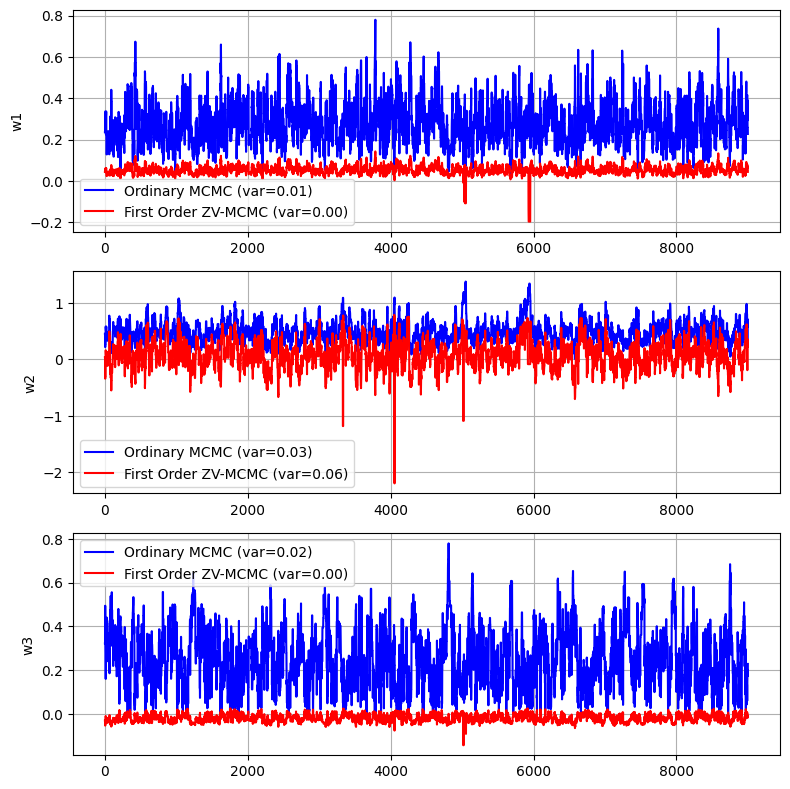

In [216]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Première figure
variance_1 = echant_sim_10[:,0][1000:].var()
variance_2 = omega_tilde_1ss[1000:].var()
axs[0].plot(range(10001), echant_sim_10[:,0][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[0].plot(range(10001), omega_tilde_1ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[0].set_ylabel('w1')
axs[0].legend()
axs[0].grid()

# Deuxième figure
variance_1 = echant_sim_10[:,1][1000:].var()
variance_2 = omega_tilde_2ss[1000:].var()
axs[1].plot(range(10001), echant_sim_10[:,1][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[1].plot(range(10001), omega_tilde_2ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[1].set_ylabel('w2')
axs[1].legend()
axs[1].grid()

# Troisième figure
variance_1 = echant_sim_10[:,2][1000:].var()
variance_2 = omega_tilde_3ss[1000:].var()
axs[2].plot(range(10001), echant_sim_10[:,2][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[2].plot(range(10001), omega_tilde_3ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[2].set_ylabel('w3')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()


Nous remarquons qu'il y a bien réduction de variance, ce qui était prévisible. Néanmoins, les $\omega_i$ et les $\tilde{\omega_i}$ n'ont pas visuellement la même moyenne. Bien ça soit une seule trajectoire, c'est le signe d'un grand problème vu que $ \mathbb{E}_{\pi}[\omega_i] = \mathbb{E}_{\pi}[\tilde{\omega}_i] $ est au fondement de toute la méthode Zero-Variance. <br>

Ce décalage entre $\omega_i$ et $\tilde{\omega_i}$ est dû à des variables de contrôle qui ne sont pas de moyenne empirique nulle. Ainsi, nous soupçonnons que le problème provient du calcul des variables de contrôle. Dans ce qui suit, nous explorons une autre approche itérative pour les calculer pour remplacer notre ancienne approche calculatoire.

Celle-ci se repose sur l'expression d'une variable de contrôle $ z_i $, donnée par :

$$ z_i = \frac{\partial \ln \pi}{\partial \omega_i} = \frac{\omega_i}{2\sigma^2(\omega_i)} + \frac{1}{4} \sum_{t=1}^{T} \frac{1}{h_t} \frac{\partial h_t}{\partial \omega_i} - \frac{1}{4} \sum_{t=1}^{T} \frac{r_t^2}{h_t^2} \frac{\partial h_t}{\partial \omega_i}, \quad i = 1, 2, 3
$$


In [230]:
def z1(x,r,var):
    Z = 0
    h = 0 

    for i in range(1, len(r)):
        h = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (1-x[2]**(i))/(1-x[2]) * (-(0.5/h) + (0.5 * r[i]**2)/(h**2))
    return -1/2 * (- x[0]/var[0] + Z)

def z2(x , r,var):
    Z = 0
    h_t = 0
    dht_domega2 = 0 #initial derivatves of h wrt alpha (x[1])
    
    for i in range(1, len(r)):
        h = h_t
        dht_domega2 = r[i-1]**2 + x[2]*dht_domega2
        h_t = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (dht_domega2) * (-(0.5/h_t) + (0.5 * r[i]**2)/(h_t**2))
    return -1/2 * (- x[1]/var[1] + Z)


def z3(x , r, var):
    Z = 0
    h_t = 0
    dht_domega3 = 0 #initial derivatves of h wrt beta (x[2])
    for i in range(1, len(r)):
        h = h_t
        dht_domega3 = h + x[2]*dht_domega3
        h_t = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (dht_domega3) * (-(0.5/h_t) + (0.5 * r[i]**2)/(h_t**2))
    return -1/2 * (- x[2]/var[2] + Z)

def calcul_z_2(echant, r, var):
    """
    Cette fonction calcule le vecteur des variables de contrôle suivant la première méthode,
    en faisont appel aux fonctions z1(), z2() et z3().

    Args:
        echant (array): échantillon du vecteur des paramètres omega_1, omega_2 et omega_3.
        h (list) : échantillon des données de volatilité (h_t).
        r (list) : données des rendements logarithmques (r_t).
        var_emp (array): Liste des variances empiriques estimées pour omega_1, omega_2 et omega_3.

    Returns:
        array: une matrice où les variables z_1, z_2, et z_3 sont empilées en colonnes.
    """
    Z1 = []
    Z2 = []
    Z3 = []

    for x in echant:
        Z1.append(z1(x, r, var))
        Z2.append(z2(x, r, var))
        Z3.append(z3(x, r, var))
    return np.column_stack([Z1, Z2, Z3])

In [231]:
CV1_sim_2_c = calcul_z_2(echant_sim_2, y[:100], np.var(echant_sim_2, axis = 0))
CV1_sim_2_l = calcul_z_2(echant_sim_10, y[:100], np.var(echant_sim_10, axis = 0))

In [232]:
# Définition des omega_tilde 

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1 = combi_omega(0, echant_sim_2, CV1_sim_2_c, CV1_sim_2_l)
omega_tilde_1 = echant_sim_10[:,0] - combi_omega1
omega_tilde_1ss = enlever_outliers(omega_tilde_1)

# ------------------------------------- Omega_2----------------------------------------------------------------

combi_omega2 = combi_omega(1, echant_sim_2, CV1_sim_2_c, CV1_sim_2_l)
omega_tilde_2 = echant_sim_10[:,1] - combi_omega2
omega_tilde_2ss = enlever_outliers(omega_tilde_2)

# ------------------------------------- Omega_3----------------------------------------------------------------

combi_omega3 = combi_omega(2, echant_sim_2, CV1_sim_2_c, CV1_sim_2_l)
omega_tilde_3 = echant_sim_10[:,2] - combi_omega3
omega_tilde_3ss = enlever_outliers(omega_tilde_3)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.616
Model:                            OLS   Adj. R-squared (uncentered):              0.615
Method:                 Least Squares   F-statistic:                              1847.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                        0.00
Time:                        05:12:50   Log-Likelihood:                          1097.8
No. Observations:                3001   AIC:                                     -2190.
Df Residuals:                    2998   BIC:                                     -2172.
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

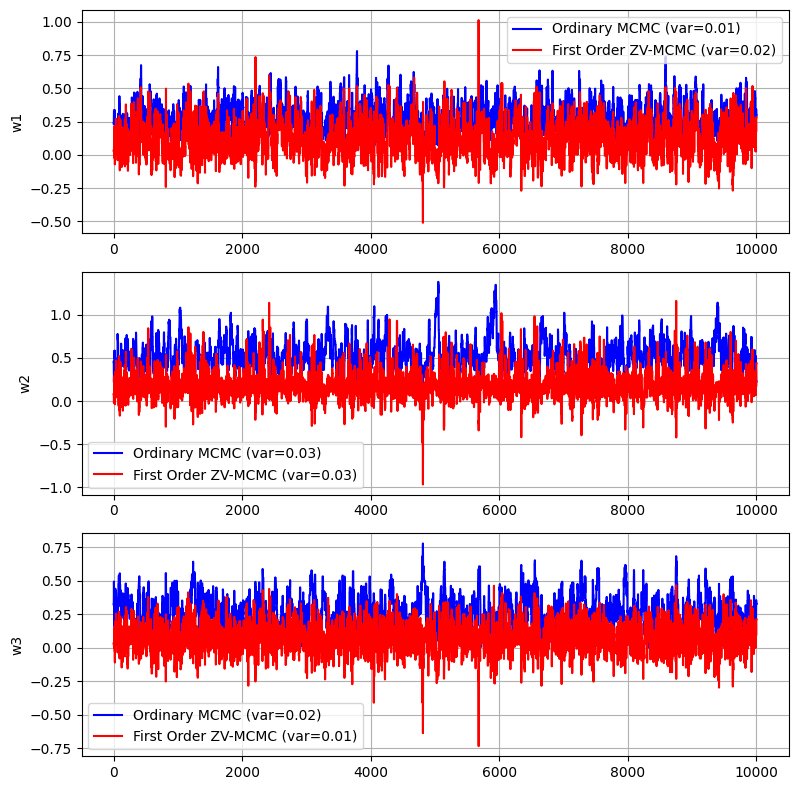

In [233]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Première figure
variance_1 = echant_sim_10[:,0][1000:].var()
variance_2 = omega_tilde_1ss[1000:].var()
axs[0].plot(range(10001), echant_sim_10[:,0][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[0].plot(range(10001), omega_tilde_1ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[0].set_ylabel('w1')
axs[0].legend()
axs[0].grid()

# Deuxième figure
variance_1 = echant_sim_10[:,1][1000:].var()
variance_2 = omega_tilde_2ss[1000:].var()
axs[1].plot(range(10001), echant_sim_10[:,1][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[1].plot(range(10001), omega_tilde_2ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[1].set_ylabel('w2')
axs[1].legend()
axs[1].grid()

# Troisième figure
variance_1 = echant_sim_10[:,2][1000:].var()
variance_2 = omega_tilde_3ss[1000:].var()
axs[2].plot(range(10001), echant_sim_10[:,2][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[2].plot(range(10001), omega_tilde_3ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[2].set_ylabel('w3')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

In [124]:
def calculate_means(x):
    return [x[:,0].mean(), x[:,1].mean(), x[:,2].mean()]

print("Moyennes des variables de contrôle suivant l'approche 1 (échantillon à partir des données simulées) :", calculate_means(CV1_sim_1_l))
print("Moyennes des variables de de contrôle suivant l'approche 2 (échantillon à partir des données simulées) :", calculate_means(CV1_sim_2_l))

Moyennes des variables de contrôle suivant l'approche 1 (échantillon à partir des données simulées) : [1167.5727347059542, -51896222995.17674, 320.54106377118967]
Moyennes des variables de de contrôle suivant l'approche 2 (échantillon à partir des données simulées) : [7.440742701028014, 7.07934989234736, 8.162567113019652]


Le décalage a l'air d'avoir diminué. Nous pouvons le vérifier en regardant la moyenne empirique des variables de contrôle avec les deux approches. Elle a bien diminué en valeur absolue pour les 3 variables. En revanche, les résultats, en terme de réduction de variance, sont assez décevants. En effet, la variance a diminué pour $\omega_3$, est restée la même pour $\omega_3$ et a augmenté pour $\omega_1$. <br>

Pour les données réelles, nous se limiterons à la première approche calculatoire.

Dans ce qui suit, nous calculons les variables contrôle suivant les deux approches et en utilisant les échantillons de paramètres obtenus à partir de la courte simulation MCMC (3000 itérations).

In [126]:
# On estime la variance conditionnelle des données réelles en estimant les omegas par les moyennes empiriques de l'échantillon généré

omega1 = echant_reel_2[:,0].mean()
omega2 = echant_reel_2[:,1].mean()
omega3 = echant_reel_2[:,2].mean()
h_reel = np.zeros(len(r[:100])) 

for t in range(1,len(r[:100])) :
    h_reel[t] = omega1 + omega2 * h_reel[t-1] + omega3 * r[t-1]**2


In [127]:
# Calcul des variables de contrôle d'ordre 1 pour les données réelles 

CV1_reel_1_c = calcul_z_1(echant_reel_2, h_reel, r[:100], np.var(echant_reel_2, axis = 0))
CV1_reel_1_l = calcul_z_1(echant_reel_10, h_reel, r[:100], np.var(echant_reel_10, axis = 0))

In [128]:
# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1_reel = combi_omega(0, echant_reel_2, CV1_reel_1_c, CV1_reel_1_l)
omega_tilde_1_reel = echant_reel_10[:,1] - combi_omega1_reel
omega_tilde_1ss_reel = enlever_outliers(omega_tilde_1_reel)

# ------------------------------------- Omega_2----------------------------------------------------------------
combi_omega2_reel = combi_omega(1, echant_reel_2, CV1_reel_1_c, CV1_reel_1_l)
omega_tilde_2_reel = echant_reel_10[:,1] - combi_omega2_reel
omega_tilde_2ss_reel = enlever_outliers(omega_tilde_2_reel)

# ------------------------------------- Omega_3----------------------------------------------------------------
combi_omega3_reel = combi_omega(2, echant_reel_2, CV1_reel_1_c, CV1_reel_1_l)
omega_tilde_3_reel = echant_reel_10[:,1] - combi_omega3_reel
omega_tilde_3ss_reel = enlever_outliers(omega_tilde_3_reel)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.116e+08
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                        0.00
Time:                        21:58:33   Log-Likelihood:                          22493.
No. Observations:                3001   AIC:                                 -4.498e+04
Df Residuals:                    2998   BIC:                                 -4.496e+04
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

ValueError: x and y must have same first dimension, but have shapes (10001,) and (9001,)

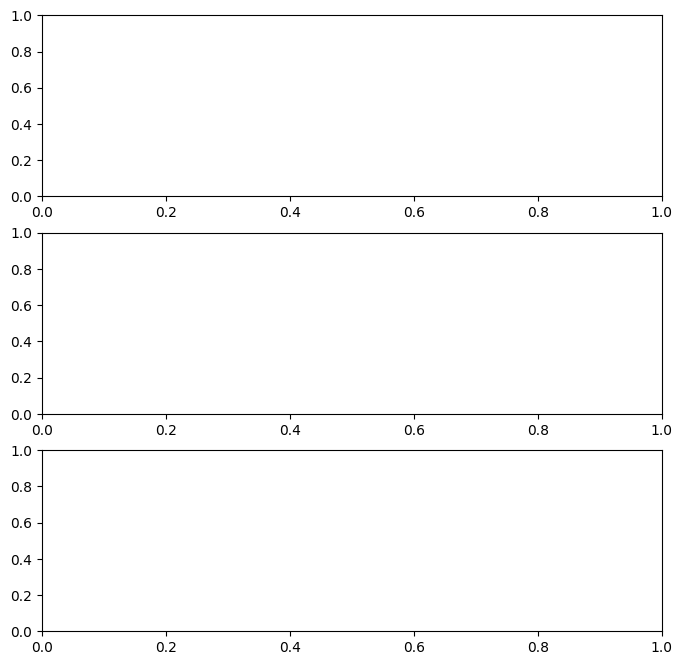

In [226]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Première figure
variance_1 = echant_reel_10[1000:,0].var()
variance_2 = omega_tilde_1ss_reel[1000:].var()
axs[0].plot(range(10001), echant_reel_10[1000:,0], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[0].plot(range(10001), omega_tilde_1ss_reel[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[0].set_ylabel('w1')
axs[0].legend()
axs[0].grid()

# Deuxième figure
variance_1 = echant_reel_10[1000:,1].var()
variance_2 = omega_tilde_2ss_reel[1000:].var()
axs[1].plot(range(10001), echant_reel_10[1000:,1], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[1].plot(range(10001), omega_tilde_2ss_reel[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[1].set_ylabel('w2')
axs[1].legend()
axs[1].grid()

# Troisième figure
variance_1 = echant_reel_10[1000:,2].var()
variance_2 = omega_tilde_3ss_reel[1000:].var()
axs[2].plot(range(10001), echant_reel_10[1000:,2], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[2].plot(range(10001), omega_tilde_3ss_reel[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[2].set_ylabel('w3')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()